Dependencies

In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers  import L2, L1


Data processing

In [5]:
train_directory = './Datasets/train'
val_directory = './Datasets/validation'
CLASS_NAMES = 'Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise'

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.01,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE":3 ,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 7,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
}

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 28709 files belonging to 7 classes.


In [7]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99
)

Found 3564 files belonging to 7 classes.


In [8]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 62.,  62.,  62.],
         [ 62.,  62.,  62.],
         [ 62.,  62.,  62.],
         ...,
         [ 46.,  46.,  46.],
         [ 46.,  46.,  46.],
         [ 46.,  46.,  46.]],

        [[ 62.,  62.,  62.],
         [ 62.,  62.,  62.],
         [ 62.,  62.,  62.],
         ...,
         [ 46.,  46.,  46.],
         [ 46.,  46.,  46.],
         [ 46.,  46.,  46.]],

        [[ 62.,  62.,  62.],
         [ 62.,  62.,  62.],
         [ 62.,  62.,  62.],
         ...,
         [ 46.,  46.,  46.],
         [ 46.,  46.,  46.],
         [ 46.,  46.,  46.]],

        ...,

        [[206., 206., 206.],
         [206., 206., 206.],
         [206., 206., 206.],
         ...,
         [ 36.,  36.,  36.],
         [ 36.,  36.,  36.],
         [ 36.,  36.,  36.]],

        [[206., 206., 206.],
         [206., 206., 206.],
         [206., 206., 206.],
         ...,
         [ 36.,  36.,  36.],
         [ 36.,  36.,  36.],
       

Data visualization

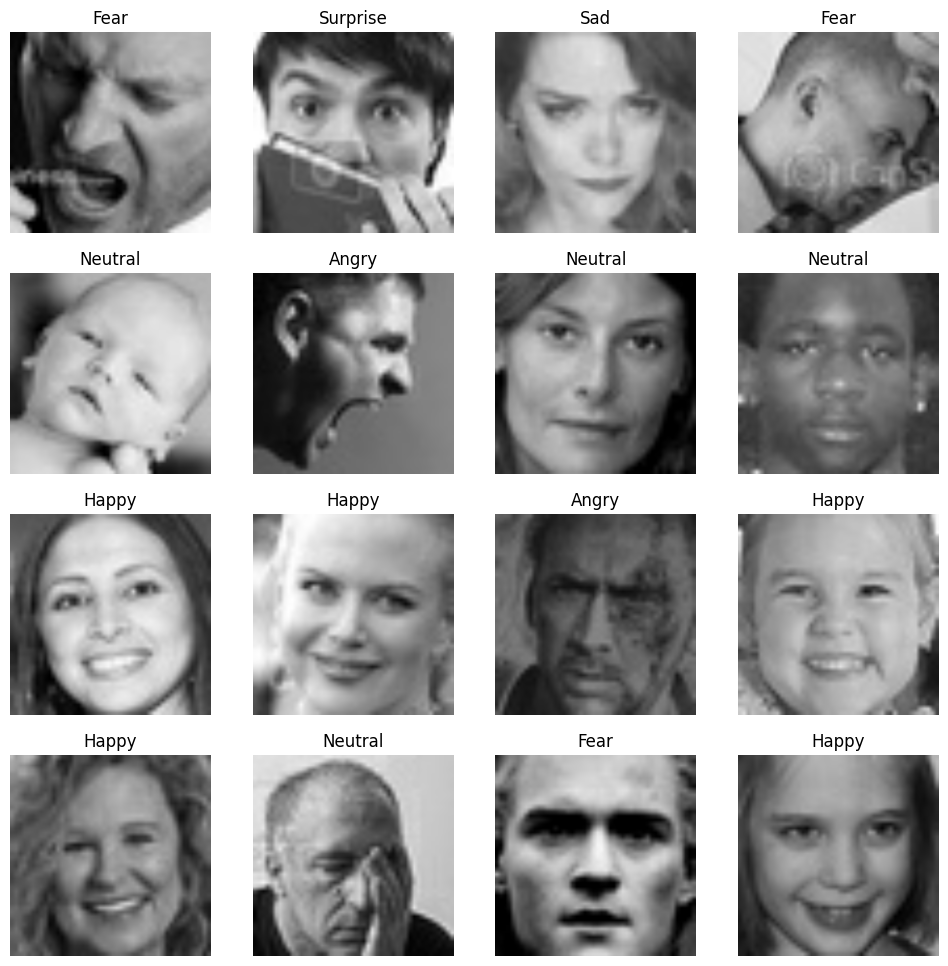

In [9]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.0)
        emotion_name = CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()] # Extracting the integer label
        plt.title(emotion_name)  # Display the emotion label
        plt.axis('off')

In [10]:
training_dataset = (
    train_dataset.prefetch(tf.data.AUTOTUNE)
)

In [11]:
validation_dataset = (
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [13]:
resize_rescale_layers = tf.keras.Sequential()

# Add Resizing layer
resize_rescale_layers.add(tf.keras.layers.Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))

# Add Rescaling layer
resize_rescale_layers.add(tf.keras.layers.Rescaling(1./255))

Model Build

In [14]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    Rescaling(1. / 255, name='rescaling'),

    Conv2D(filters=CONFIGURATION['N_FILTERS'], kernel_size=CONFIGURATION['KERNEL_SIZE'], strides=CONFIGURATION['N_STRIDES'],
           activation='relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'], strides=CONFIGURATION['N_STRIDES'] * 2),

    Conv2D(filters=CONFIGURATION['N_FILTERS'] * 2 + 4, kernel_size=CONFIGURATION['KERNEL_SIZE'], strides=CONFIGURATION['N_STRIDES'],
           activation='relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'], strides=CONFIGURATION['N_STRIDES'] * 2),

    Flatten(),

    Dense(CONFIGURATION['N_DENSE_1'], activation='relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION['DROPOUT_RATE']),

    Dense(512, activation='relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),

     Dense(256, activation='relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(CONFIGURATION['N_DENSE_2'], activation='relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(64, activation='relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(7, activation='softmax')
])

model.summary()

C:\Users\Jash\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    62,981,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,687,927 (242.95 MB)

 Trainable params: 63,683,915 (242.93 MB)

 Non-trainable params: 4,012 (15.67 KB)

In [15]:
loss_function = CategoricalCrossentropy(from_logits=False)

In [16]:
metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2,name='top_k_accuracy')]

In [17]:
model.compile(optimizer = Adam(learning_rate=1e-3),loss=loss_function,metrics=metrics)

Model train

In [18]:
history = model.fit(training_dataset,validation_data = validation_dataset,epochs=CONFIGURATION['N_EPOCHS'])

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 479s 527ms/step - accuracy: 0.2893 - loss: 1.8523 - top_k_accuracy: 0.4752 - val_accuracy: 0.2433 - val_loss: 1.9757 - val_top_k_accuracy: 0.4279
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 464s 517ms/step - accuracy: 0.4215 - loss: 1.5027 - top_k_accuracy: 0.6223 - val_accuracy: 0.2301 - val_loss: 2.0474 - val_top_k_accuracy: 0.4167
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 462s 514ms/step - accuracy: 0.5008 - loss: 1.3256 - top_k_accuracy: 0.6929 - val_accuracy: 0.4248 - val_loss: 1.6478 - val_top_k_accuracy: 0.6103
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 462s 514ms/step - accuracy: 0.5846 - loss: 1.1352 - top_k_accuracy: 0.7664 - val_accuracy: 0.4153 - val_loss: 1.8592 - val_top_k_accuracy: 0.5948
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 462s 514ms/step - accuracy: 0.6477 - loss: 0.9812 - top_k_accuracy: 0.8165 - val_accuracy: 0.4158 - val_loss: 2.0256 - val_top_k_accuracy: 0.6041
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 461s 514ms/step - accuracy: 0.

Testing the model

In [5]:
import cv2
import numpy as np
import tensorflow as tf

# Load face detection and emotion recognition models
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
emotion_model = tf.keras.models.load_model('./Emotions.h5')

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Start capturing video from the webcam
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not open webcam")
    exit()

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if ret:
        # Convert frame to grayscale for face detection
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Process each detected face
        for (x, y, w, h) in faces:
            # Extract the face region and preprocess it for emotion recognition
            face_roi = frame[y:y+h, x:x+w]
            preprocessed_face = cv2.resize(face_roi, (256, 256))  # Resize the face image to 256x256
            preprocessed_face = np.expand_dims(preprocessed_face, axis=0)  # Add batch dimension

            # Perform emotion recognition inference with the model
            predictions = emotion_model.predict(preprocessed_face)
            predicted_emotion = emotion_labels[np.argmax(predictions)]

            # Display the predicted emotion label
            cv2.putText(frame, f"Emotion: {predicted_emotion}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Display the frame with face detection and predicted emotions
        cv2.imshow('Real-Time Emotion Detection', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━